In [57]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
# %matplotlib inline
import copy; import sys; import os
from IPython.display import Image, display
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this
import ipywidgets as wid; wid.HTMLMath('$\LaTeX$')

HTMLMath(value='$\\LaTeX$')

Ali Al Kadhim and Harrison B. Prosper <br>
Department of Physics, Florida State University <br>


In particle physics, the most important experiment is a counting experiment, represented by a Poisson probability model, where $N$ is the observed count and $\theta$ is a nuissance parameter, hence the probability model is $P(N|\theta) = \text{Poisson}(N,\theta)$.
where the most important parameter is the cross section $\sigma$, which is related to the mean event count $N = \sigma \mathcal{L} +b$. 


# For the two-parameter problem, the Poisson mean$=\theta+\nu$, and the probability model is given by

$$p(N,M|\theta, \nu) = \text{Poiss}(N; \theta+\nu)\text{Poiss}(M;\nu) =L(\theta, \nu)= \frac{e^{-(\theta+\nu)} (\theta+\nu)^N }{N !} \ \frac{e^{-\nu} \nu^M}{M !}$$



Where $\nu$ is the nuissance parameter, $\theta$ is the paramter of interest (for which we want to estimate upper limits). 


### Observed Data:

   * $N$ (counts for signal)
   * $M$ (counts for background)

### Parameters:

* $\theta$ (parameter of interest)

* $\nu$ (nuissance parameter)

### Auxiliary (simulated) Data (simulated on-the-fly for each observation)

* $n$

* $m$


    
The standard procedure for removal of nuissance parameters is Bayesian marginalization, but in this study we adopt LFI with frequentest methods.

In this notebook we generate data comprising the quadruplets $(Z_i, \theta_i, \nu_i, N_i, M_i)$ where 

$
\begin{align}
\theta & \sim \textrm{uniform}(0, 20), \\
\nu & \sim \textrm{uniform}(0, 20), \\
n & \sim \textrm{poisson}(\theta + \nu),\\
m & \sim \textrm{poisson}(\nu),\\
N & \sim \textrm{uniform}(0,10),\\
M & \sim \textrm{uniform}(0, 10), \textrm{ and } \\
Z & = I[ \lambda_{\textrm{gen}} \leq \lambda_D (D, \theta) ],
\end{align}
$

where the size of each of these samples is $B'$, $I$ is the indicator function, and $\lambda_D (D, \theta)= \lambda(N, M, \theta)$ is our chosen test statistic

$$ \lambda = - 2 \log{\frac{p(n,m|\theta, \hat{\nu}(\theta) )}{ p(n,m|\hat{\theta}, \hat{\nu}(\theta) )}} = -2 \log \frac{L_{\text{prof}} \big(n, m, \theta, \hat{\nu}(\theta) \big) }{L_{\text{prof}} \big( n, m, \hat{\theta}_{\text{MLE}}, \hat{\nu}(\theta) \big)}$$

Where $L_{\text{prof}} (n, m, \theta, \hat{\nu}(\theta))$ is the profiled likelihood. The maximum likelihood estimate of $\hat{\theta}$, 
$$\hat{\theta}_{\text{MLE}}=n-m$$, and

$$\log{p(n,m|\theta,\nu)} = -(\theta+\nu)+n\log{(\theta+\nu)|-\nu+m\log{\nu}} + \text{constants}$$
The MLE $\hat{\nu}(\theta)$ is attained by solving $\frac{\partial \log{p(n,m|\theta,\nu)}}{ \partial \nu} =0$ leading to 

$$\hat{\nu}(\theta)=\left(g+\sqrt{g^2 + 8 m \theta} \right)/4$$
where $g \equiv n+m-2 \theta$.

And since $\nu$ has been marginalized in the likelihood, $\lambda$ only depends on $\theta,\n,m$ (but is used as a test statistic for $\theta$ only), and is only "slighly" dependent on $n,m$ since they're really not the observed data but instead simulations on the fly. $\lambda=\lambda(\theta,n,m)$

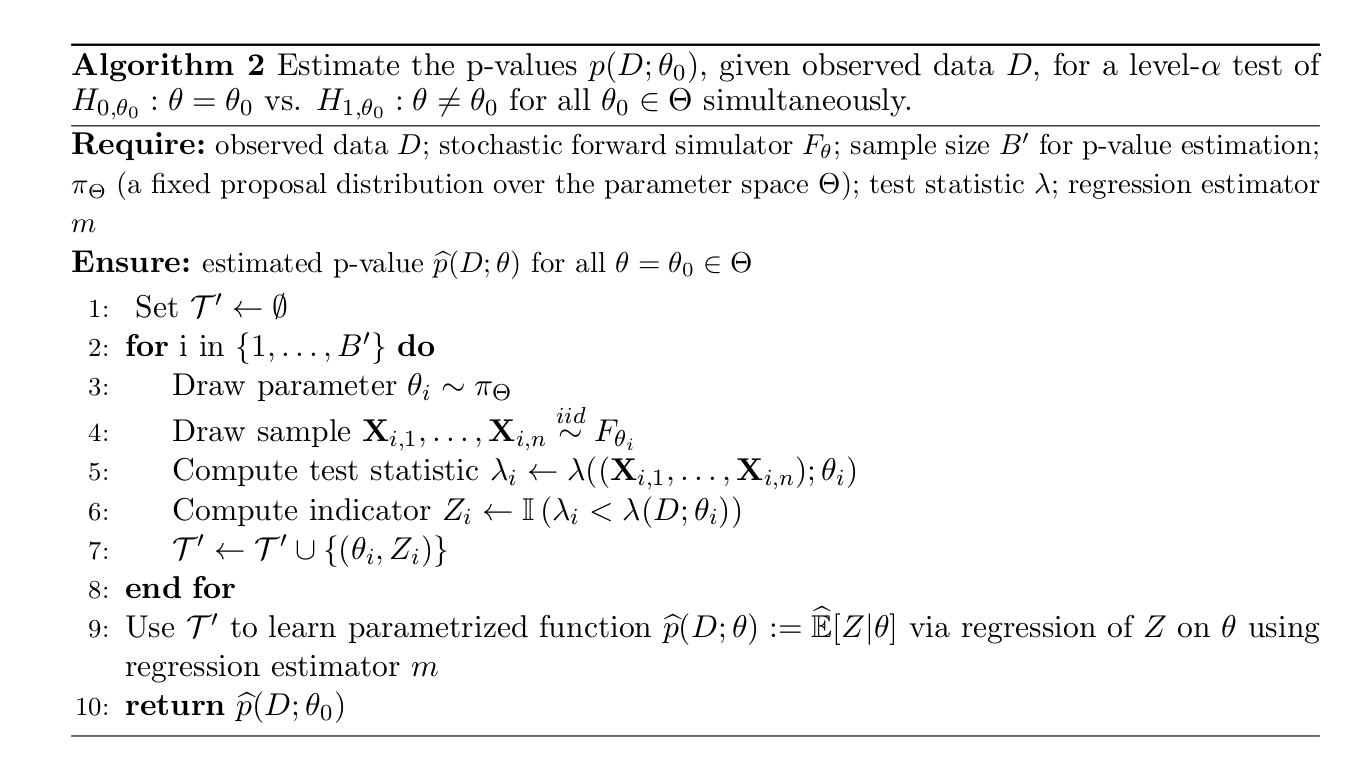

In [32]:
algorithm2 = Image('images/Algorithm2.jpg'); display(algorithm2)

In [62]:
from src.utils import lambda_test, L_prof, theta_hat

chi2_exp_size=40

def run_sim(theta, nu, MLE, lambda_size):
    """Sample n ~ Pois(theta+nu), m ~ Pois(nu), and compute lambda(theta, n, m)
    return (n, m, lambda_), where each are np arrays of length lambda_size
    """
    n = st.poisson.rvs(theta+nu, size=lambda_size)
    m = st.poisson.rvs(nu, size=lambda_size)
    lambda_ = lambda_test(theta, n, m, MLE=MLE)
    return (n, m, lambda_)

def run_sims(points, MLE):
    """
    Run an entire simulation, that is, generate n and m from 
    run_sim above, and calculate lambda, for
    input: a tuple of (theta, nu) scalars
    
    Reurns:df, lambda_results
    where lambda_results is a list of tuples (n, m, lambda_, theta, nu)
    and df is just a dataframe of [n,m,lambda,theta,nu]

    """
    lambda_results=[]
    df=pd.DataFrame()
    for p in points:
        theta, nu = p
        df['theta']=theta
        df['nu']=nu
        n, m, lambda_ = run_sim(theta, nu, MLE, lambda_size =chi2_exp_size)
        df['n'] = n
        df['m'] = m
        df['lambda']=lambda_
        lambda_results.append((n, m, lambda_, theta, nu))
    
        print( '\n \n (theta, nu) =  (%.f, %.f) \n ' % (theta, nu) )
        print(f'\t \t with associated n, =  {n}, \n \n \t \t m = {m}, \n \n \t \t lambda = {lambda_}'  )
    return df, lambda_results

def plot_one(lambda_, theta, nu, ax):
    """Histogram the CDF of  lambda_t = -2log(Lp(theta)/Lp(theta_hat)), 
    for a given (fixed) theta and nu.
    Also, plot the actual CDF of a chi^2 distribution with 1 free parameter 
    (since only theta is left after we profile nu) """
    ftsize = 16; xmin= 0; xmax= 10#I think xmax is the max of uniform(theta) if I remember correctly
    ymin= 0; ymax= 1
    x_range = (xmin, xmax)
    y_range = (ymin, ymax)
    ax.set_xlim(x_range); ax.set_ylim(y_range)
    ax.set_xlabel(r'$\lambda (\theta, n, m, \hat{\nu}(\theta))$',fontsize=ftsize)
    ax.set_ylabel(r'cdf$(\lambda)$', fontsize=ftsize)
    ##########HISTOGRAM CDF OF LAMBDA####################
    ax.hist(lambda_, bins=5*xmax, range=x_range,
    color=(0.8,0.8,0.9),
    density=True, cumulative=True,
    histtype='stepfilled', edgecolor='black', label=r'CDF$(\lambda)$')
    ############################################################
    ########### HISTOGRAM CDF OF THE CHI2 OF OF X WITH 1 DOF
    #x is not theta, that's the whole point of Wilks thm, x is an arbitrary RV
    x = np.arange(0, xmax, 0.2)
    y = st.chi2.cdf(x, 1)
    ax.plot(x, y, color='blue',
    linewidth=2, label=r'CDF$(\chi^2_1)$')
    # annotate
    xwid = (xmax-xmin)/12
    ywid = (ymax-ymin)/12
    xpos = xmin + xwid/2
    ypos = ymin + ywid*2
    ax.text(xpos, ypos,
    r'$ \theta = %d, \nu = %d$' % (theta, nu),
    fontsize=ftsize)
    ax.legend(loc='upper right',fontsize=10)

1. Generate one scalar $\theta$ and one scalar $\nu$
2. Generate $\lambda(\theta,\nu)$ of size $N$, the distribution of this $\lambda$ will approach the CDF of a $\chi^2_{dof}(x)$ of an RV of one dof (since $\theta$ is the only free parameter left)
4. Observe that this test statistc will be dependent on the value of $\nu$ in the non-MLE case, which is not desirable since we want to be insensetive to nuissance parameters for maximal statistal power


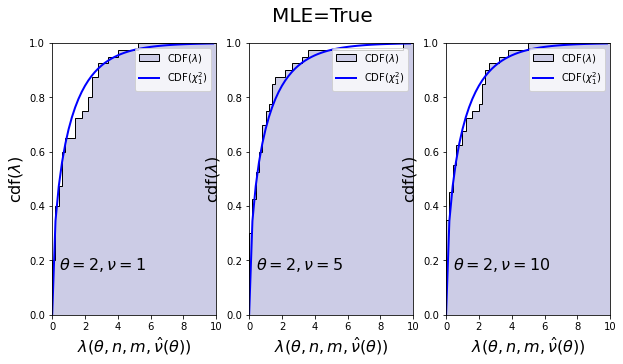

In [63]:
#points=(theta,nu)
points_1 = (2, 1)
points_2 = (2, 5)
points_3 = (2, 10)
MLE=True
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_2 = run_sim(theta=points_2[0], nu=points_2[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_3 = run_sim(theta=points_3[0], nu=points_3[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5))
plot_one(lambda_1, points_1[0], points_1[1], ax[0])
plot_one(lambda_2, points_2[0], points_2[1], ax[1])
plot_one(lambda_3, points_3[0], points_3[1], ax[2])
fig.suptitle('MLE=True', fontsize=20); plt.show()

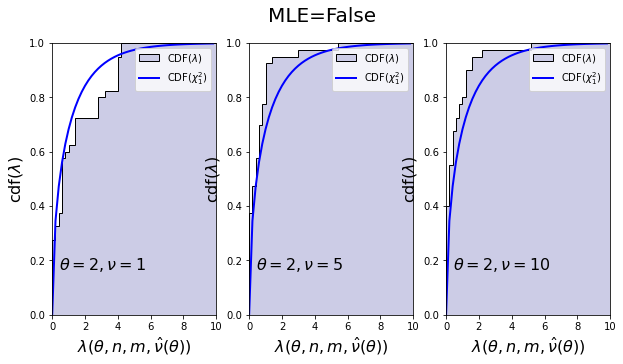

In [50]:
#points=(theta,nu)
points_1 = (2, 1)
points_2 = (2, 5)
points_3 = (2, 10)
MLE=False
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_2 = run_sim(theta=points_2[0], nu=points_2[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_3 = run_sim(theta=points_3[0], nu=points_3[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5))
plot_one(lambda_1, points_1[0], points_1[1], ax[0])
plot_one(lambda_2, points_2[0], points_2[1], ax[1])
plot_one(lambda_3, points_3[0], points_3[1], ax[2])
fig.suptitle('MLE=False', fontsize=20); plt.show()

Generate 6 pairs (tuples) of $(\theta, \nu)$ values

In [51]:
MLE=True
points = [(theta, nu) for theta, nu in 
          zip(np.random.randint(low=1,high=4,size=6), 
              np.random.randint(low=0,high=4,size=6))]

In [52]:
df, results = run_sims(points, MLE=True)


 
 (theta, nu) =  (1, 2) 
 
	 	 with associated n, =  [6 0 5 5 5 2 4 5 4 2 1 1 0 5 1 1 1 4 2 2 7 1 4 4 3 3 6 5 1 2 3 1 2 0 2 3 6
 5 0 5], 
 
 	 	 m = [2 5 4 1 3 1 4 3 4 2 2 2 2 2 5 4 3 1 2 4 0 1 2 0 5 3 1 1 1 2 2 1 2 0 3 2 1
 1 0 4], 
 
 	 	 lambda = [ 1.1946283   8.93147181 -0.          1.68553575  0.12667401 -0.
  0.12404321  0.12667401  0.12404321  0.2427715   1.25679667  1.25679667
  4.77258872  0.59696003  4.32474935  3.23711108  2.20517244  0.87752024
  0.2427715   1.48289494  7.70406053  0.45197431  0.17072609  3.54517744
  1.11713652  0.16443338  2.61450511  1.68553575  0.45197431  0.2427715
 -0.          0.45197431  0.2427715   2.          0.78075725 -0.
  2.61450511  1.68553575  2.         -0.        ]

 
 (theta, nu) =  (1, 1) 
 
	 	 with associated n, =  [3 3 1 5 1 1 4 3 2 1 1 4 3 1 3 5 0 3 2 2 2 1 1 2 0 1 0 1 1 1 1 4 2 2 1 5 0
 2 2 5], 
 
 	 	 m = [0 1 0 1 0 1 1 2 1 1 2 2 2 1 1 0 1 0 0 4 1 3 2 0 2 2 0 0 0 1 3 4 1 4 2 0 2
 0 1 0], 
 
 	 	 lambda = [ 2.15888308  0.26469562 

In [53]:
df.head()

,theta,nu,n,m,lambda
0,3,3,1,0,1.802775
1,3,3,11,1,5.067121
2,3,3,5,1,0.178305
3,3,3,10,2,2.345807
4,3,3,8,2,0.981053


In [55]:
n, m, lambda_, theta, nu =results[1]
print(f'results[1] =  (n1, m1, lambda1, theta1, nu1) =  (  \n {n}, \n {m}, \n {lambda_}, \n {theta}, \n {nu})' )
print(f'''\n (n.shape, m.shape, lambda_.shape, theta.size, nu.size) = 
      ({n.shape}, \t {m.shape}, \t {lambda_.shape}, \t {theta.size}, \t {nu.size})''')

results[1] =  (n1, m1, lambda1, theta1, nu1) =  (  
 [3 3 1 5 1 1 4 3 2 1 1 4 3 1 3 5 0 3 2 2 2 1 1 2 0 1 0 1 1 1 1 4 2 2 1 5 0
 2 2 5], 
 [0 1 0 1 0 1 1 2 1 1 2 2 2 1 1 0 1 0 0 4 1 3 2 0 2 2 0 0 0 1 3 4 1 4 2 0 2
 0 1 0], 
 [ 2.15888308  0.26469562 -0.          1.68553575 -0.          0.45197431
  0.87752024 -0.         -0.          0.45197431  1.25679667  0.17072609
 -0.          0.45197431  0.26469562  4.93147181  3.38629436  2.15888308
  0.77258872  1.48289494 -0.          2.20517244  1.25679667  0.77258872
  4.77258872  1.25679667  2.         -0.         -0.          0.45197431
  2.20517244  0.12404321 -0.          1.48289494  1.25679667  4.93147181
  4.77258872  0.77258872 -0.          4.93147181], 
 1, 
 1)

 (n.shape, m.shape, lambda_.shape, theta.size, nu.size) = 
      ((40,), 	 (40,), 	 (40,), 	 1, 	 1)


In [56]:
data_2_param=pd.read_csv('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv', nrows=10000, usecols=['theta','nu', 'N', 'M'])
data_2_param.head()

,theta,nu,N,M
0,19.597712,10.387874,5,6
1,13.316589,0.052172,1,6
2,9.565929,2.031794,3,6
3,19.145463,8.600285,9,3
4,7.994914,7.861142,8,2


In [110]:
thetaMin, thetaMax =  0, 3
nuMin, nuMax = 0, 3
Mmin, Mmax =  0 , 3
Nmin, Nmax =  0,3

def generate_training_data(Bprime, MLE, save_data=False):
    """Generate the training data, that is, features=[theta, nu, N, M], targets=Z"""
    #sample theta and nu from uniform(0,20)
    theta = st.uniform.rvs(thetaMin, thetaMax, size=Bprime)
    # nu = st.uniform.rvs(nuMin, nuMax, size=Bprime)
    nu=3
    #n,m ~ F_{\theta,\nu}, ie our simulator. sample n from a Poisson with mean theta+nu 
    n = st.poisson.rvs(theta+ nu, size=Bprime)
    #sample m from a poisson with mean nu
    m = st.poisson.rvs(nu, size=Bprime)
    
    #sample our observed counts (N,M), which take the place of D
    N = np.random.randint(Nmin, Nmax, size=Bprime)
    M = np.random.randint(Mmin, Mmax, size=Bprime)
    SUBSAMPLE=10
    print('n=', n[:SUBSAMPLE])
    print('m=', m[:SUBSAMPLE])
    print('N=', N[:SUBSAMPLE])
    print('M=', M[:SUBSAMPLE])
    lambda_gen = lambda_test(theta, n, m, MLE)
    print('lambda_gen= ', lambda_gen[:SUBSAMPLE])
    lambda_D = lambda_test(theta, N, M, MLE)
    print('lambda_D= ', lambda_D[:SUBSAMPLE])
    #if lambda_gen <= lambda_D: Z=1, else Z=0
    Z = (lambda_gen <= lambda_D).astype(np.int32)
    
    data_2_param = {'Z' : Z, 'theta' : theta, 'nu': nu, 'N':N, 'M':M}

    data_2_param = pd.DataFrame.from_dict(data_2_param)
    if save_data:
        data_2_param.to_csv('data/two_parameters_N_M_Uniformly_sampled_1M.csv')

    print('\n')
    print(data_2_param.describe())
    return data_2_param

In [111]:
Train_data_MLE_True = generate_training_data(Bprime=10000, MLE=True, save_data=False)

n= [2 6 3 4 5 3 4 5 7 2]
m= [4 3 1 1 1 3 8 4 3 3]
N= [1 1 0 1 0 2 0 0 0 1]
M= [2 0 2 1 1 1 2 2 2 1]
lambda_gen=  [8.36049701e-01 6.76861602e-02 3.09566660e-03 1.86837031e-01
 8.81104536e-01 1.75915637e-01 2.37095420e+00 5.83655352e-05
 6.21181376e-01 1.46622770e+00]
lambda_D=  [5.03286585e-01 8.51211425e-01 6.55103172e+00 1.58917779e+00
 5.04390371e+00 4.02730312e-04 5.43442103e+00 4.72675457e+00
 5.88039746e+00 1.27030657e+00]


                  Z         theta       nu             N             M
count  10000.000000  10000.000000  10000.0  10000.000000  10000.000000
mean       0.656200      1.491572      3.0      0.988400      0.987400
std        0.474999      0.860477      0.0      0.817271      0.818479
min        0.000000      0.000316      3.0      0.000000      0.000000
25%        0.000000      0.753290      3.0      0.000000      0.000000
50%        1.000000      1.488428      3.0      1.000000      1.000000
75%        1.000000      2.220539      3.0      2.000000      2.00000

In [131]:
def binsize(data_df):
    """ decide on the number of bins in a histogram according to Struge's rule"""
    bin_count = int(np.ceil(np.log2(data_df.shape[0])) + 1)
    return bin_count

XMIN  = 0
XMAX  = 20
NU    = 3#set
Bprime = 1000
# D is a list of (N,M) pairs
D     = [(1, 0), (2, 0), (3, 0), 
         (1, 1), (2, 1), (3, 1)]
XBINS = int(np.ceil(np.log2(Bprime)) + 1)

def hist_data(thetamin, thetamax,
              nu, N, M,
              xbins=XBINS,
             MLE=True):

    theta = st.uniform.rvs(thetamin, thetamax, size=Bprime)
    n = st.poisson.rvs(theta + nu, size=Bprime)
    m = st.poisson.rvs(nu, size=Bprime)
    
    Z = (lambda_test(theta, n, m, MLE=MLE) < 
         lambda_test(theta, N, M, MLE=MLE)).astype(np.int32)

    xrange = (xmin, xmax)

    # weighted histogram   (count the number of ones per bin)
    y1, bb = np.histogram(theta, 
                          bins=xbins, 
                          range=xrange, 
                          weights=Z)
    
    # unweighted histogram (count number of ones and zeros per bin)
    yt, _ = np.histogram(theta, 
                         bins=xbins, 
                         range=xrange)

    y =  y1 / yt    
    
    return y, bb, bin_centers

Compare the histogrammed function $h(\theta, \nu, N, M)$ to the ML prediction functino $f(\theta, \nu, N, M)$ (which is trained to regress $Z$). 

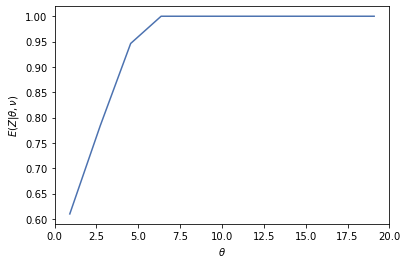

In [124]:
def plot_data(thetamin, thetamax, nu, D, 
              func=None,
              xbins=XBINS,
              gfile='fig_data2_%s.png' % WHICH, 
              fgsize=(10, 6)):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=2, 
                           ncols=3, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    ax = ax.flatten()
    
    for j, (N, M) in enumerate(D):
        
        y, bb = hist_data(thetamin, thetamax, nu, N, M,
            xbins=XBINS,
             MLE=True)
    
        ax[j].set_xlim(xmin, xmax)
        ax[j].set_ylim(0, 1)
        ax[j].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j].plot(x, y, 'b', lw=2, label='approx')
        
        if func:
            p, _ = func(nu, N, M)
            ax[j].plot(x, p, 'r', lw=2, label='model')
        
        ax[j].grid(True, which="both", linestyle='-')
        ax[j].text(10.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   fontsize=FONTSIZE) 

        ax[j].text(10.1, 0.30, r'$\nu = %5.1f$' % nu, 
                   fontsize=FONTSIZE) 

        ax[j].legend(loc='upper right')
        
    # hide unused sub-plots
    for k in range(j+1, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    print('saving..', gfile)
    plt.savefig(gfile)
    plt.show()

In [129]:
theta = st.uniform.rvs(0, 1, size=10)
n = st.poisson.rvs(theta + nu, size=10)
m = st.poisson.rvs(3, size=10)

In [130]:
n.shape

(10,)